In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.primitives import Sampler

In [2]:
# Function to generate a random graph
def generate_random_graph(n):
    p = 0.5  # Probability for edge creation, approximately 50% of a fully connected graph
    graph = nx.erdos_renyi_graph(n, p)
    while len(graph.edges()) < n * (n - 1) / 4:
        graph = nx.erdos_renyi_graph(n, p)
    for (u, v) in graph.edges():
        graph.edges[u, v]['weight'] = np.random.randint(1, 10)
    return graph

# Function to draw the graph
def draw_graph(graph):
    pos = nx.spring_layout(graph)
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw(graph, pos, with_labels=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()

In [3]:
def max_cut_hamiltonian(graph):
    """Create the Hamiltonian for the Max-Cut problem for the given graph."""
    n = len(graph.nodes)
    pauli_list = []
    coeffs = []
    for i, j in graph.edges:
        z = ['I'] * n
        z[i] = 'Z'
        z[j] = 'Z'
        pauli_list.append(Pauli(''.join(z)))
        coeffs.append(0.5*graph.edges[i, j]['weight'])
    return SparsePauliOp(pauli_list, coeffs)

In [4]:
def extract_partitions_from_bitstring(bitstring, n):
    partitions = {'A': [], 'B': []}
    for i in range(n):
        if bitstring[i] == '0':
            partitions['A'].append(i)
        else:
            partitions['B'].append(i)
    return partitions

In [5]:
# # Function to solve max-cut using QAOA
# def solve_max_cut_qaoa(graph, p=1):

#     qubit_op = max_cut_hamiltonian(graph)
#     backend = Aer.get_backend('aer_simulator')
#     sampler = Sampler()
#     qaoa = QAOA(optimizer=COBYLA(maxiter=250), reps=p, sampler=sampler)
#     result = qaoa.compute_minimum_eigenvalue(qubit_op)
#     eigenstate = result.eigenstate
#     eigenstate=dict(eigenstate)
#     bitstring=max(eigenstate, key=eigenstate.get)
#     # bitstring = eigenstate.argmax()  # Get the most likely bitstring
#     bitstring = f'{bitstring:0{len(graph.nodes)}b}'  # Convert to binary string
#     partitions = extract_partitions_from_bitstring(bitstring, len(graph.nodes))
#     return result.eigenvalue.real, result.eigenstate, partitions,bitstring

In [5]:
def solve_max_cut_qaoa(graph):

    qubit_op = max_cut_hamiltonian(graph)
    diag=np.diag(qubit_op.to_matrix())
    min_eigenval=np.min(diag)
    bitstring=np.argmin(diag)
    bitstring = f'{bitstring:0{len(graph.nodes)}b}'  # Convert to binary string
    partitions = extract_partitions_from_bitstring(bitstring, len(graph.nodes))
    return diag,min_eigenval,partitions,bitstring

In [6]:
# Function for exhaustive search
def exhaustive_search(graph):
    n = len(graph.nodes)
    max_cut_value = 0
    best_cut = None
    best_partition = None
    for b in range(1 << n):
        cut_value = 0
        cut_partition = extract_partitions_from_bitstring(f'{b:0{n}b}', n)
        for (i, j) in graph.edges:
            if ((b >> i) & 1) != ((b >> j) & 1):
                cut_value += graph.edges[i, j]['weight']
        if cut_value > max_cut_value:
            max_cut_value = cut_value
            best_cut = b
            best_partition = cut_partition
    return max_cut_value, best_cut,best_partition

In [7]:
def run_experiment(num_graphs=20):
    results = []
    for _ in range(num_graphs):
        n = np.random.randint(7, 11)
        graph = generate_random_graph(n)
        # draw_graph(graph)
        
        max_cut_value_classical,_, best_partition_classical = exhaustive_search(graph)
        _, max_cut_value_quantum, best_partition_quantum,_ = solve_max_cut_qaoa(graph)

        results.append({
            'num_nodes': n,
            'max_cut_value_classical': max_cut_value_classical,
            'partition_classical': best_partition_classical,
            'max_cut_value_quantum': max_cut_value_quantum,
            'partition_quantum': best_partition_quantum
        })
        print(f"Classical Max-Cut: Partition: {best_partition_classical}")
        print(f"Quantum Max-Cut: Partition: {best_partition_quantum}")


In [8]:
# Running the experiment
results = run_experiment()

Classical Max-Cut: Partition: {'A': [0, 3, 4, 6, 8], 'B': [1, 2, 5, 7, 9]}
Quantum Max-Cut: Partition: {'A': [0, 2, 3, 4, 7, 8], 'B': [1, 5, 6, 9]}
Classical Max-Cut: Partition: {'A': [0, 4, 5, 8], 'B': [1, 2, 3, 6, 7]}
Quantum Max-Cut: Partition: {'A': [0, 3, 4, 8], 'B': [1, 2, 5, 6, 7]}
Classical Max-Cut: Partition: {'A': [0, 4, 5, 7], 'B': [1, 2, 3, 6, 8]}
Quantum Max-Cut: Partition: {'A': [0, 2, 5, 6, 7], 'B': [1, 3, 4, 8]}
Classical Max-Cut: Partition: {'A': [0, 1, 2, 3, 5], 'B': [4, 6, 7, 8]}
Quantum Max-Cut: Partition: {'A': [0, 1, 2, 4], 'B': [3, 5, 6, 7, 8]}
Classical Max-Cut: Partition: {'A': [0, 2, 3, 5, 8], 'B': [1, 4, 6, 7]}
Quantum Max-Cut: Partition: {'A': [0, 3, 5, 6, 8], 'B': [1, 2, 4, 7]}
Classical Max-Cut: Partition: {'A': [0, 3, 4], 'B': [1, 2, 5, 6, 7]}
Quantum Max-Cut: Partition: {'A': [0, 1, 2, 5, 6], 'B': [3, 4, 7]}
Classical Max-Cut: Partition: {'A': [0, 1, 3, 5], 'B': [2, 4, 6, 7, 8, 9]}
Quantum Max-Cut: Partition: {'A': [0, 1, 2, 3, 5, 7], 'B': [4, 6, 8, 9]}


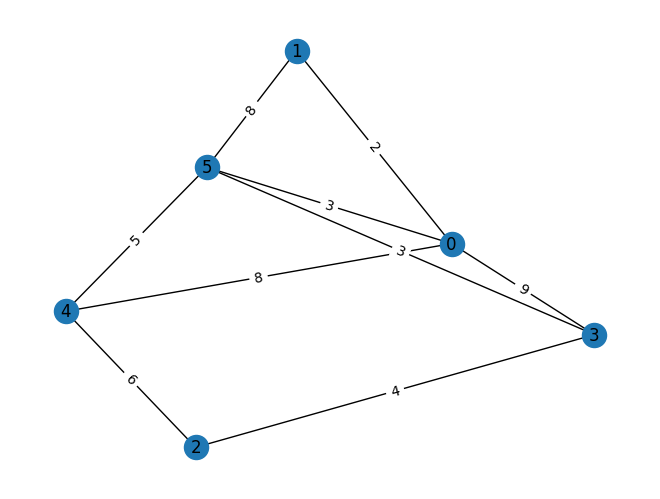

SparsePauliOp(['ZZIIII', 'ZIIZII', 'ZIIIZI', 'ZIIIIZ', 'IZIIIZ', 'IIZZII', 'IIZIZI', 'IIIZIZ', 'IIIIZZ'],
              coeffs=[2.+0.j, 9.+0.j, 8.+0.j, 3.+0.j, 8.+0.j, 4.+0.j, 6.+0.j, 3.+0.j, 5.+0.j])

In [25]:
from qiskit.quantum_info import Pauli, SparsePauliOp

def max_cut_hamiltonian(graph):
    n = len(graph.nodes)
    pauli_list = []
    coeffs = []
    for i, j in graph.edges:
        z = ['I'] * n
        z[i] = 'Z'
        z[j] = 'Z'
        pauli_list.append(Pauli(''.join(z)))
        coeffs.append(graph.edges[i, j]['weight'])
    return SparsePauliOp(pauli_list, coeffs)

n =6#np.random.randint(7, 11)
graph = generate_random_graph(n)
draw_graph(graph)

qubit_op = max_cut_hamiltonian(graph)
qubit_op

In [23]:
exhaustive_search(graph)

(15, 6, {'A': [0, 3], 'B': [1, 2]})

In [26]:
solve_max_cut_qaoa(graph)

(array([ 48.+0.j,  10.+0.j,  10.+0.j,  -8.+0.j,  16.+0.j, -10.+0.j,
        -22.+0.j, -28.+0.j,  28.+0.j, -10.+0.j,  14.+0.j,  -4.+0.j,
         12.+0.j, -14.+0.j,  -2.+0.j,  -8.+0.j,  28.+0.j,  22.+0.j,
        -10.+0.j,   4.+0.j,  -4.+0.j,   2.+0.j, -42.+0.j, -16.+0.j,
          8.+0.j,   2.+0.j,  -6.+0.j,   8.+0.j,  -8.+0.j,  -2.+0.j,
        -22.+0.j,   4.+0.j,   4.+0.j, -22.+0.j,  -2.+0.j,  -8.+0.j,
          8.+0.j,  -6.+0.j,   2.+0.j,   8.+0.j, -16.+0.j, -42.+0.j,
          2.+0.j,  -4.+0.j,   4.+0.j, -10.+0.j,  22.+0.j,  28.+0.j,
         -8.+0.j,  -2.+0.j, -14.+0.j,  12.+0.j,  -4.+0.j,  14.+0.j,
        -10.+0.j,  28.+0.j, -28.+0.j, -22.+0.j, -10.+0.j,  16.+0.j,
         -8.+0.j,  10.+0.j,  10.+0.j,  48.+0.j]),
 (-42+0j),
 {'A': [0, 2, 5], 'B': [1, 3, 4]},
 '010110')